In [1]:
from keras.callbacks import LearningRateScheduler

# Define the Learning Rate Scheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

# Define the directories for the TRAIN dataset
EOSINOPHIL_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL"]
LYMPHOCYTE_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE"]
MONOCYTE_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE"]
NEUTROPHIL_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL"]

# Define the directories for the TEST dataset
EOSINOPHIL_test_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL"]
LYMPHOCYTE_test_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/LYMPHOCYTE"]
MONOCYTE_test_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/MONOCYTE"]
NEUTROPHIL_test_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL"]

# Define the directories for the TEST_SAMPLES dataset
EOSINOPHIL_test_sample_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/EOSINOPHIL"]
LYMPHOCYTE_test_sample_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/LYMPHOCYTE"]
MONOCYTE_test_sample_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/MONOCYTE"]
NEUTROPHIL_test_sample_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/NEUTROPHIL"]


2024-05-07 06:55:18.176632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 06:55:18.176729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 06:55:18.309208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import pandas as pd

# Define the directories for the TRAIN, TEST, and TEST_SAMPLES datasets
dict_lists = [
    EOSINOPHIL_dirs, LYMPHOCYTE_dirs, MONOCYTE_dirs, NEUTROPHIL_dirs,
    EOSINOPHIL_test_dirs, LYMPHOCYTE_test_dirs, MONOCYTE_test_dirs, NEUTROPHIL_test_dirs,
    EOSINOPHIL_test_sample_dirs, LYMPHOCYTE_test_sample_dirs, MONOCYTE_test_sample_dirs, NEUTROPHIL_test_sample_dirs
]

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'] * 3  # Repeat for each dataset

filepaths = []
labels = []

for i, dir_list in enumerate(dict_lists):
    for dir_path in dir_list:
        flist = os.listdir(dir_path)
        for f in flist:
            fpath = os.path.join(dir_path, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

# Storing image file PATHs in a column and their labels in another column
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)

print("df head: \n", bloodCell_df.head())
print("Labels value counts: \n", bloodCell_df["labels"].value_counts())
print("df shape: \n", bloodCell_df.shape)


df head: 
                                            filepaths      labels
0  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
1  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
2  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
3  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
4  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
Labels value counts: 
 labels
NEUTROPHIL    3171
EOSINOPHIL    3133
LYMPHOCYTE    3109
MONOCYTE      3102
Name: count, dtype: int64
df shape: 
 (12515, 2)


In [5]:
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

def deblur_image(image):
    """Deblurs the image using a Wiener filter."""
    image = np.array(image)  # Convert PIL Image to numpy array
    psf = np.ones((5, 5)) / 25
    img = cv2.filter2D(image,-1,psf)
    return Image.fromarray(img.astype(np.uint8))  # Convert numpy array back to PIL Image

def apply_contrast_enhancement(image):
    """Increase the contrast of the image."""
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(1.2)  # Increase contrast
    return enhanced_image

def apply_brightness_enhancement(image):
    """Increase the brightness of the image."""
    enhancer = ImageEnhance.Brightness(image)
    enhanced_image = enhancer.enhance(1.05)  # Increase brightness
    return enhanced_image

def apply_sharpness_enhancement(image):
    """Increase the sharpness of the image."""
    enhancer = ImageEnhance.Sharpness(image)
    enhanced_image = enhancer.enhance(20)  # Increase sharpness
    return enhanced_image

def preprocess_and_save_image(image, save_dir, image_name):
    """Apply all enhancements to the image and save the final preprocessed image."""
    # Apply enhancements
    image = apply_contrast_enhancement(image)
    image = apply_brightness_enhancement(image)
    image = apply_sharpness_enhancement(image)
    image = deblur_image(image)

    # Create the directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Save the final preprocessed image
    save_path = os.path.join(save_dir, f'{image_name}_preprocessed.jpg')
    image.save(save_path)

    return image

# Define the directories for the TRAIN dataset
EOSINOPHIL_TRAIN_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL"]
LYMPHOCYTE_TRAIN_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE"]
MONOCYTE_TRAIN_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE"]
NEUTROPHIL_TRAIN_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL"]

# Define the directories for the TEST dataset
EOSINOPHIL_TEST_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL"]
LYMPHOCYTE_TEST_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/LYMPHOCYTE"]
MONOCYTE_TEST_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/MONOCYTE"]
NEUTROPHIL_TEST_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL"]

# Define the directories for the TEST_SIMPLE dataset
EOSINOPHIL_TEST_SIMPLE_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/EOSINOPHIL"]
LYMPHOCYTE_TEST_SIMPLE_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/LYMPHOCYTE"]
MONOCYTE_TEST_SIMPLE_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/MONOCYTE"]
NEUTROPHIL_TEST_SIMPLE_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE/NEUTROPHIL"]

# Directories to save the preprocessed images
save_dirs = {
    'TRAIN': {
        'EOSINOPHIL': '/kaggle/working/preprocessed-imagess/TRAIN/EOSINOPHIL',
        'LYMPHOCYTE': '/kaggle/working/preprocessed-imagess/TRAIN/LYMPHOCYTE',
        'MONOCYTE': '/kaggle/working/preprocessed-imagess/TRAIN/MONOCYTE',
        'NEUTROPHIL': '/kaggle/working/preprocessed-imagess/TRAIN/NEUTROPHIL'
    },
    'TEST': {
        'EOSINOPHIL': '/kaggle/working/preprocessed-imagess/TEST/EOSINOPHIL',
        'LYMPHOCYTE': '/kaggle/working/preprocessed-imagess/TEST/LYMPHOCYTE',
        'MONOCYTE': '/kaggle/working/preprocessed-imagess/TEST/MONOCYTE',
        'NEUTROPHIL': '/kaggle/working/preprocessed-imagess/TEST/NEUTROPHIL'
    },
    'TEST_SIMPLE': {
        'EOSINOPHIL': '/kaggle/working/preprocessed-imagess/TEST_SIMPLE/EOSINOPHIL',
        'LYMPHOCYTE': '/kaggle/working/preprocessed-imagess/TEST_SIMPLE/LYMPHOCYTE',
        'MONOCYTE': '/kaggle/working/preprocessed-imagess/TEST_SIMPLE/MONOCYTE',
        'NEUTROPHIL': '/kaggle/working/preprocessed-imagess/TEST_SIMPLE/NEUTROPHIL'
    }
}

# Loop over each dataset type (TRAIN, TEST, TEST_SIMPLE)
for dataset_type, cell_types in save_dirs.items():
    # Loop over each cell type (EOSINOPHIL, LYMPHOCYTE, MONOCYTE, NEUTROPHIL)
    for cell_type, save_dir in cell_types.items():
        # Get the directory for this dataset type and cell type
        dir_list = globals()[f'{cell_type}_{dataset_type}_dirs']

        # Loop over each image in the directory
        for image_name in os.listdir(dir_list[0]):
            # Load the image
            image = Image.open(os.path.join(dir_list[0], image_name))

            # Preprocess and save the image
            preprocess_and_save_image(image, save_dir, image_name)


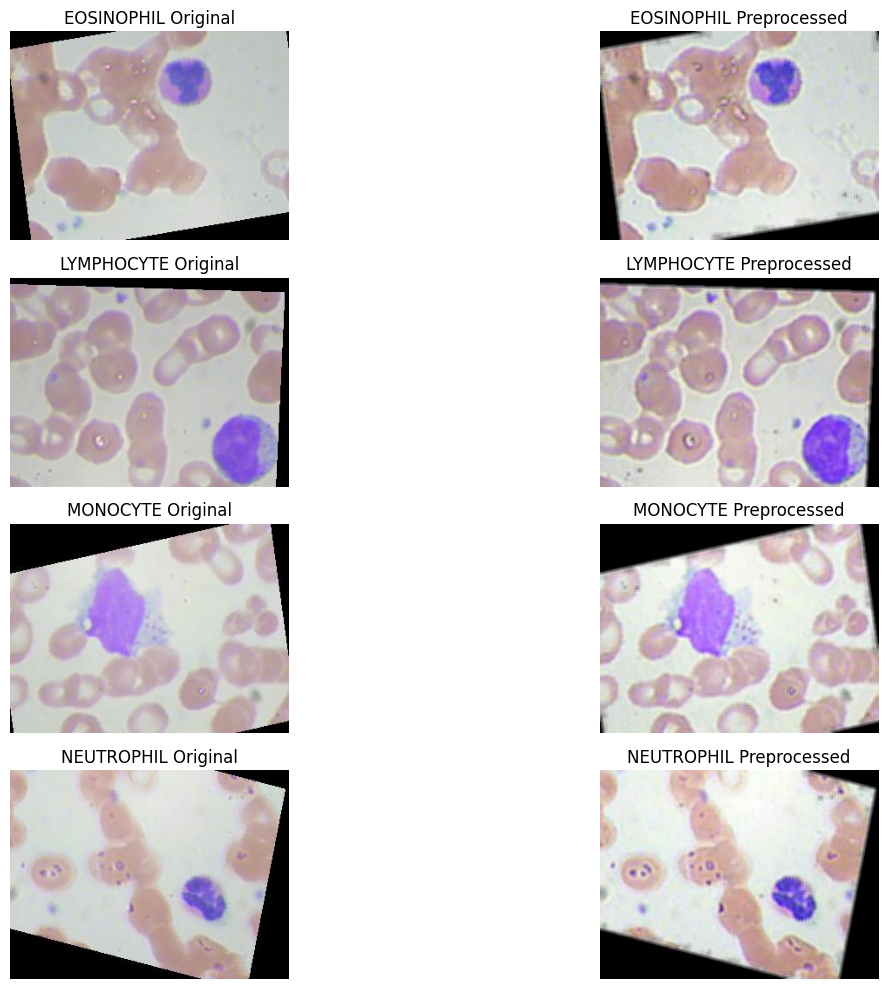

In [10]:
import matplotlib.pyplot as plt
import random


def preprocess_and_save_all_images(class_dir, save_dir):
    """Apply all enhancements to all images in the class directory and save the final preprocessed images."""
    try:
        # Get the list of image files for this class
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.jpeg') or f.endswith('.png')]

        # Initialize list to store preprocessed images
        preprocessed_images = []

        # Loop over each image file
        for image_file in image_files:
            # Load original image
            image = Image.open(image_file)

            # Apply enhancements
            image = apply_contrast_enhancement(image)
            image = apply_brightness_enhancement(image)
            image = apply_sharpness_enhancement(image)
            image = deblur_image(image)

            # Save the final preprocessed image
            image_name = os.path.splitext(os.path.basename(image_file))[0]  # Get the image name without extension
            save_path = os.path.join(save_dir, f'{image_name}_preprocessed.jpg')
            image.save(save_path)

            # Append preprocessed image to the list
            preprocessed_images.append(save_path)  # Save the path of the preprocessed image

        return image_files, preprocessed_images  # Return the paths of the original and preprocessed images
    except Exception as e:
        print(f"Error processing images in {class_dir}: {e}")
        return []


# Define the directories for the TRAIN dataset
EOSINOPHIL_TRAIN_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL"]
LYMPHOCYTE_TRAIN_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE"]
MONOCYTE_TRAIN_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE"]
NEUTROPHIL_TRAIN_dirs = [r"/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL"]

# Apply preprocessing to all images in each class
eosinophil_image_files, eosinophil_preprocessed_images = preprocess_and_save_all_images(EOSINOPHIL_TRAIN_dirs[0], '/kaggle/working/preprocessed-imagess/TRAIN/EOSINOPHIL')
lymphpcyte_image_files, lymphpcyte_preprocessed_images = preprocess_and_save_all_images(LYMPHOCYTE_TRAIN_dirs[0], '/kaggle/working/preprocessed-imagess/TRAIN/LYMPHOCYTE')
monocyte_image_files, monocyte_preprocessed_images = preprocess_and_save_all_images(MONOCYTE_TRAIN_dirs[0], '/kaggle/working/preprocessed-imagess/TRAIN/MONOCYTE')
neutrophil_image_files, neutrophil_preprocessed_images = preprocess_and_save_all_images(NEUTROPHIL_TRAIN_dirs[0], '/kaggle/working/preprocessed-imagess/TRAIN/NEUTROPHIL')

# Select a random original and preprocessed image from each class
eosinophil_original_image, eosinophil_preprocessed_image = random.choice(list(zip(eosinophil_image_files, eosinophil_preprocessed_images)))
lymphpcyte_original_image, lymphpcyte_preprocessed_image = random.choice(list(zip(lymphpcyte_image_files, lymphpcyte_preprocessed_images)))
monocyte_original_image, monocyte_preprocessed_image = random.choice(list(zip(monocyte_image_files, monocyte_preprocessed_images)))
neutrophil_original_image, neutrophil_preprocessed_image = random.choice(list(zip(neutrophil_image_files, neutrophil_preprocessed_images)))

# Create a figure with a grid layout
fig, axes = plt.subplots(4, 2, figsize=(15, 10))

# Display the original and preprocessed images
axes[0, 0].imshow(Image.open(eosinophil_original_image))
axes[0, 0].axis('off')
axes[0, 0].set_title('EOSINOPHIL Original')

axes[0, 1].imshow(Image.open(eosinophil_preprocessed_image))
axes[0, 1].axis('off')
axes[0, 1].set_title('EOSINOPHIL Preprocessed')

axes[1, 0].imshow(Image.open(lymphpcyte_original_image))
axes[1, 0].axis('off')
axes[1, 0].set_title('LYMPHOCYTE Original')

axes[1, 1].imshow(Image.open(lymphpcyte_preprocessed_image))
axes[1, 1].axis('off')
axes[1, 1].set_title('LYMPHOCYTE Preprocessed')

axes[2, 0].imshow(Image.open(monocyte_original_image))
axes[2, 0].axis('off')
axes[2, 0].set_title('MONOCYTE Original')

axes[2, 1].imshow(Image.open(monocyte_preprocessed_image))
axes[2, 1].axis('off')
axes[2, 1].set_title('MONOCYTE Preprocessed')

axes[3, 0].imshow(Image.open(neutrophil_original_image))
axes[3, 0].axis('off')
axes[3, 0].set_title('NEUTROPHIL Original')

axes[3, 1].imshow(Image.open(neutrophil_preprocessed_image))
axes[3, 1].axis('off')
axes[3, 1].set_title('NEUTROPHIL Preprocessed')

plt.tight_layout()
plt.show()

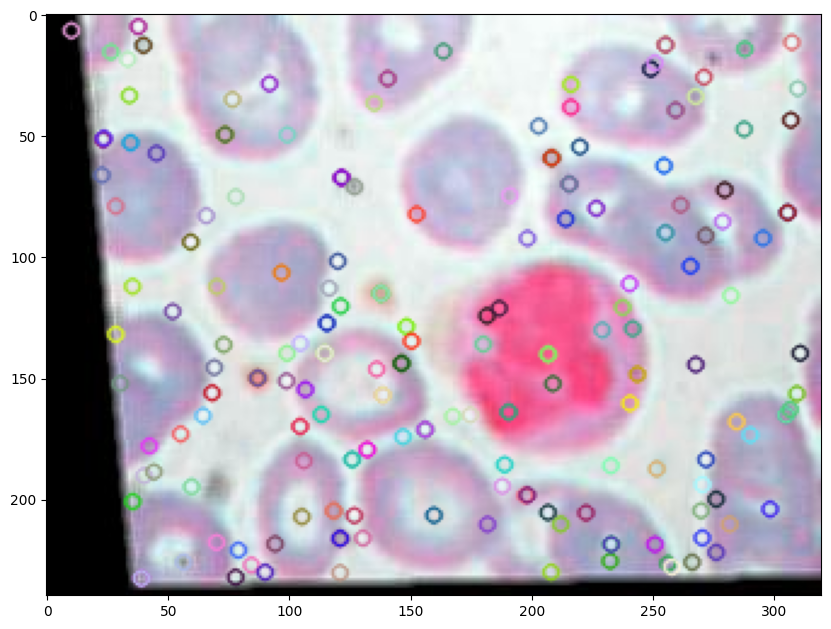

First 5 keypoints: (< cv2.KeyPoint 0x7df265f6e760>, < cv2.KeyPoint 0x7df265f6ef40>, < cv2.KeyPoint 0x7df265f6def0>, < cv2.KeyPoint 0x7df265f6ee20>, < cv2.KeyPoint 0x7df265f6f2a0>)
First descriptor: [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 122.   0.
   0.   0.   0.   0.   0.  10. 203.  15.   1.   1.   0.   0.   0.  22.
  33.   8.   2.   7.   3.   0.   0.   3.   0.   0.   0.   0.   0.   0.
   0.   0. 203.   1.   0.   0.   0.   0.   0.  16. 203.  19.   1.   1.
   0.   0.   0.  38.  69.  13.   3.   4.   1.   0.   3.  51.   1.   0.
   0.   0.   0.   0.   0.   0. 197.   0.   0.   0.   0.   0.   0.  25.
 203.   1.   0.   0.   0.   0.   3. 121.  35.   1.   0.   0.   0.   0.
  18. 125.]


In [11]:
# List all files in the directory
image_dir = '/kaggle/working/preprocessed-imagess/TRAIN/EOSINOPHIL'  # Update with your directory path
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Choose a random image file
img_path = random.choice(image_files)

# Load preprocessed image
preprocessed_image = Image.open(img_path)

# Convert back to numpy array for SIFT
enhanced_image = np.array(preprocessed_image)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(enhanced_image, None)

# Draw keypoints on the image
img_keypoints = np.empty((enhanced_image.shape[0], enhanced_image.shape[1], 3), dtype=np.uint8)
cv2.drawKeypoints(enhanced_image, keypoints, img_keypoints)

# display the image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.show()

# print some keypoints and descriptors to understand their structure
print("First 5 keypoints:", keypoints[:5])
print("First descriptor:", descriptors[0])


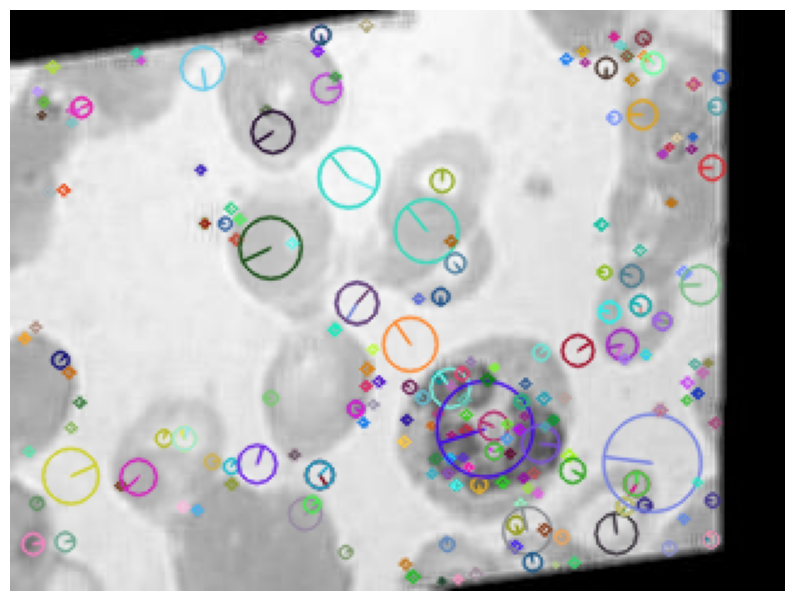

Number of keypoints detected: 222
First few descriptors:
 [[ 10.   2.   0.   0.   0.   0.   0.   1.  32.  21.   0.   0.   0.   0.
    0.   0.  31.  20.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
    1.   0.   0.   0.  32.   7.   0.   0.   0.   1.   4.  23. 160. 129.
    0.   0.   0.   0.   1.  11. 160. 160.   0.   0.   1.   1.   0.   9.
   25.  10.   0.   0.   4.   7.   5.   4.  12.   3.   1.   0.   0.   2.
   13.  20. 160.  18.   1.   0.   0.   0.   3.  76. 160.  19.   0.   0.
    0.   1.   1. 120.  35.   1.   0.   1.   1.   9.   6.  12.   6.   1.
    0.   0.   0.   3.  22.  44.  93.   1.   0.   0.   0.   0.  10. 160.
  160.   4.   1.   0.   0.   0.   1. 160.  13.   4.   4.   2.   1.   2.
    1.   4.]
 [  7.   4.   9.   6.   3.   1.   0.   1. 154.  88.   1.   0.   1.   0.
    0.   1. 154. 151.   0.   0.   1.   0.   0.   0.  27.  14.   1.   9.
   14.   2.   0.   0.  28.   7.  11.  11.   4.   0.   1.  25. 144.  29.
    0.   0.   0.   0.  18.  50. 154. 106.   0.   0.   0.   0.   2

In [12]:
# Directory to load the preprocessed images
preprocessed_dir = '/kaggle/working/preprocessed-imagess/TRAIN/EOSINOPHIL'

# List all files in the directory
image_files = [os.path.join(preprocessed_dir, f) for f in os.listdir(preprocessed_dir) if os.path.isfile(os.path.join(preprocessed_dir, f))]

# Choose a random image file
img_path = random.choice(image_files)

# Load preprocessed image
image = Image.open(img_path)

# Convert to grayscale numpy array for SIFT
enhanced_gray = np.array(image.convert('L'))

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(enhanced_gray, None)

# Draw keypoints on the image
img_with_keypoints = cv2.drawKeypoints(enhanced_gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.figure(figsize=(10, 10))
plt.imshow(img_with_keypoints, cmap='gray')  # Use cmap='gray' to display grayscale images correctly
plt.axis('off')  # Hide axis
plt.show()

# Print keypoints and descriptors if needed
print("Number of keypoints detected:", len(keypoints))
print("First few descriptors:\n", descriptors[:5])


In [13]:
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

def extract_sift_features(filepaths):
    sift = cv2.SIFT_create()
    descriptors_list = []

    for filepath in filepaths:
        try:
            # Load preprocessed image
            image = Image.open(filepath)

            # Convert to grayscale numpy array for SIFT
            gray = np.array(image.convert('L'))

            _, descriptors = sift.detectAndCompute(gray, None)

            # Aggregate descriptors into a single feature vector
            aggregated_descriptors = np.mean(descriptors, axis=0)

            descriptors_list.append(aggregated_descriptors)
        except Exception as e:
            print(f"Error processing image: {filepath}")
            # Skip the invalid image and continue processing
    return np.array(descriptors_list)

# Define the directories for the preprocessed TRAIN, TEST, and TEST_SIMPLE datasets
dataset_dirs = {
    'TRAIN': {
        'EOSINOPHIL': '/kaggle/working/preprocessed-imagess/TRAIN/EOSINOPHIL',
        'LYMPHOCYTE': '/kaggle/working/preprocessed-imagess/TRAIN/LYMPHOCYTE',
        'MONOCYTE': '/kaggle/working/preprocessed-imagess/TRAIN/MONOCYTE',
        'NEUTROPHIL': '/kaggle/working/preprocessed-imagess/TRAIN/NEUTROPHIL'
    },
    'TEST': {
        'EOSINOPHIL': '/kaggle/working/preprocessed-imagess/TEST/EOSINOPHIL',
        'LYMPHOCYTE': '/kaggle/working/preprocessed-imagess/TEST/LYMPHOCYTE',
        'MONOCYTE': '/kaggle/working/preprocessed-imagess/TEST/MONOCYTE',
        'NEUTROPHIL': '/kaggle/working/preprocessed-imagess/TEST/NEUTROPHIL'
    },
    'TEST_SIMPLE': {
        'EOSINOPHIL': '/kaggle/working/preprocessed-imagess/TEST_SIMPLE/EOSINOPHIL',
        'LYMPHOCYTE': '/kaggle/working/preprocessed-imagess/TEST_SIMPLE/LYMPHOCYTE',
        'MONOCYTE': '/kaggle/working/preprocessed-imagess/TEST_SIMPLE/MONOCYTE',
        'NEUTROPHIL': '/kaggle/working/preprocessed-imagess/TEST_SIMPLE/NEUTROPHIL'
    }
}

# Initialize list to store features and labels
features = []
labels = []

# Loop over each dataset type (TRAIN, TEST, TEST_SIMPLE)
for dataset_type, cell_types in dataset_dirs.items():
    # Loop over each cell type (EOSINOPHIL, LYMPHOCYTE, MONOCYTE, NEUTROPHIL)
    for cell_type, dir_list in cell_types.items():
        # Get the list of preprocessed image files for this class
        preprocessed_files = [os.path.join(dir_list, f) for f in os.listdir(dir_list) if f.endswith('.jpg')]

        # Extract SIFT features for all preprocessed images in this class
        class_features = extract_sift_features(preprocessed_files)

        # Append features to the list
        features.extend(class_features)

        # Append corresponding labels
        labels.extend([cell_type] * len(class_features))

# Convert the list of features and labels to a numpy array
features = np.array(features)
labels = np.array(labels)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
reduced_features = pca.fit_transform(features)

print("Original feature shape:", features.shape)
print("Reduced feature shape:", reduced_features.shape)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(reduced_features, labels)

# Print the feature ranking
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(reduced_features.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Select features based on importance
model = SelectFromModel(forest, prefit=True)
selected_features = model.transform(reduced_features)

print("Original feature shape:", reduced_features.shape)
print("Selected feature shape:", selected_features.shape)


Original feature shape: (22472, 128)
Reduced feature shape: (22472, 100)
Feature ranking:
1. feature 4 (0.039996)
2. feature 3 (0.039149)
3. feature 2 (0.035705)
4. feature 0 (0.031698)
5. feature 1 (0.023957)
6. feature 9 (0.015521)
7. feature 15 (0.015306)
8. feature 16 (0.015110)
9. feature 6 (0.014991)
10. feature 12 (0.014799)
11. feature 7 (0.014791)
12. feature 8 (0.014780)
13. feature 5 (0.014187)
14. feature 24 (0.014006)
15. feature 25 (0.013470)
16. feature 50 (0.013298)
17. feature 22 (0.012747)
18. feature 32 (0.011262)
19. feature 18 (0.011197)
20. feature 13 (0.010783)
21. feature 39 (0.010613)
22. feature 48 (0.010456)
23. feature 41 (0.010428)
24. feature 23 (0.010426)
25. feature 59 (0.009957)
26. feature 45 (0.009729)
27. feature 65 (0.009481)
28. feature 33 (0.009445)
29. feature 66 (0.009393)
30. feature 49 (0.009375)
31. feature 38 (0.009328)
32. feature 29 (0.009253)
33. feature 27 (0.009242)
34. feature 36 (0.009080)
35. feature 54 (0.008964)
36. feature 76 (0.0

Validation Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.67      0.67      0.67      1125
  LYMPHOCYTE       0.79      0.83      0.81      1085
    MONOCYTE       0.78      0.79      0.79      1109
  NEUTROPHIL       0.76      0.73      0.74      1176

    accuracy                           0.75      4495
   macro avg       0.75      0.75      0.75      4495
weighted avg       0.75      0.75      0.75      4495

Test Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.66      0.65      0.65      1147
  LYMPHOCYTE       0.77      0.82      0.79      1157
    MONOCYTE       0.77      0.76      0.76      1050
  NEUTROPHIL       0.75      0.73      0.74      1141

    accuracy                           0.74      4495
   macro avg       0.74      0.74      0.74      4495
weighted avg       0.74      0.74      0.74      4495


Confusion Matrix:
[[740 119 120 168]
 [ 97 947  54  59]
 [129  76 7

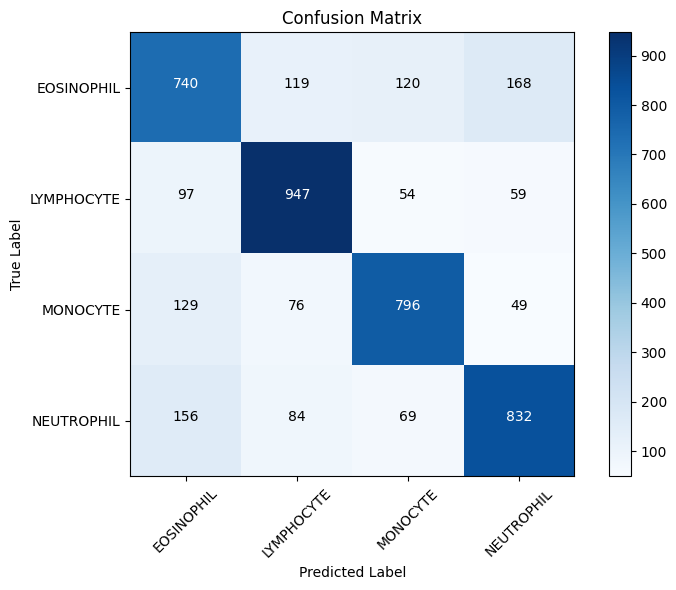

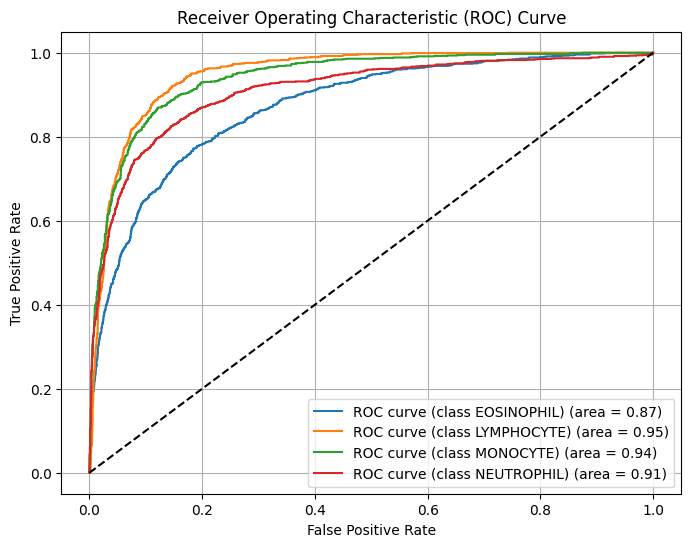

In [15]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Corresponding class labels
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Split the data into a (combined) training set and a test set
features_train_val, features_test, labels_train_val, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Split the (combined) training set into separate training and validation sets
features_train, features_val, labels_train, labels_val = train_test_split(features_train_val, labels_train_val, test_size=0.25, random_state=42)

# Create a SVM classifier
clf = svm.SVC(kernel='linear', probability=True) # Linear Kernel

# Train the model using the training sets
clf.fit(features_train, labels_train)

# Validate the model using the validation sets
labels_val_pred = clf.predict(features_val)

# Print classification report for the validation set
print("Validation Classification Report:")
print(classification_report(labels_val, labels_val_pred))

# Test the model using the test sets
labels_test_pred = clf.predict(features_test)

# Print classification report for the test set
print("Test Classification Report:")
print(classification_report(labels_test, labels_test_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(labels_test, labels_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

print("\n")

# Predict the probabilities for test dataset
y_probs = clf.predict_proba(features_test)

# Calculate ROC curve and ROC-AUC score for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(labels_test == class_labels[i], y_probs[:, i])
    roc_auc = roc_auc_score(labels_test == class_labels[i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve (class {class_labels[i]}) (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guess curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Validation Set Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.80      0.82      0.81      1125
  LYMPHOCYTE       0.87      0.85      0.86      1085
    MONOCYTE       0.86      0.85      0.86      1109
  NEUTROPHIL       0.81      0.81      0.81      1176

    accuracy                           0.83      4495
   macro avg       0.83      0.83      0.83      4495
weighted avg       0.83      0.83      0.83      4495

Test Set Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.80      0.80      0.80      1147
  LYMPHOCYTE       0.87      0.85      0.86      1157
    MONOCYTE       0.86      0.87      0.86      1050
  NEUTROPHIL       0.82      0.83      0.82      1141

    accuracy                           0.84      4495
   macro avg       0.84      0.84      0.84      4495
weighted avg       0.84      0.84      0.84      4495


Confusion Matrix:
[[923  69  61  94]
 [ 70 986  38  63]
 [ 

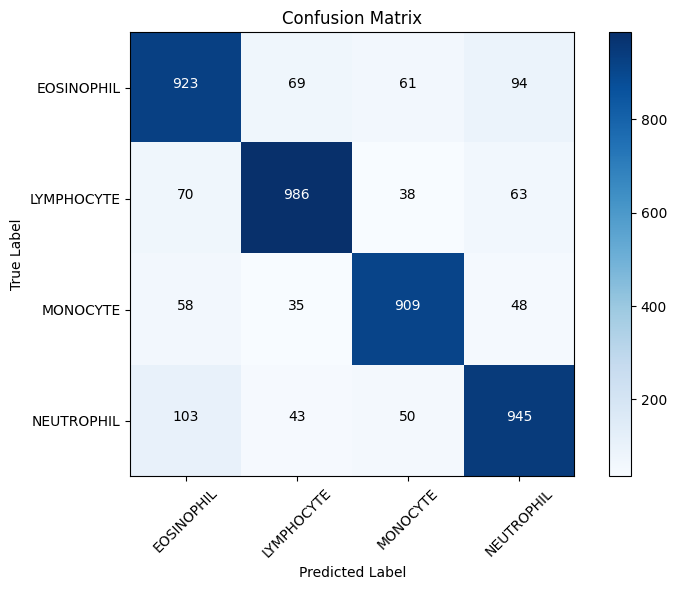

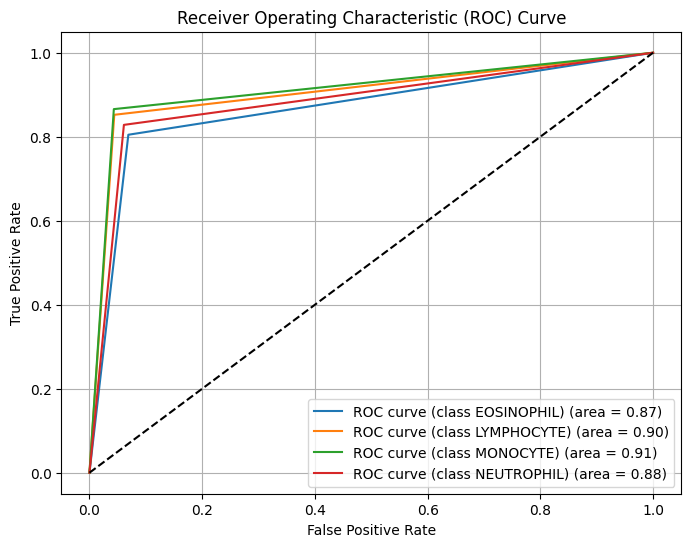

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Split the data into a (combined) training set and a test set
features_train_val, features_test, labels_train_val, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Split the (combined) training set into separate training and validation sets
features_train, features_val, labels_train, labels_val = train_test_split(features_train_val, labels_train_val, test_size=0.25, random_state=42)

# features_train, features_val, and features_test,
# Which contain the training, validation, and testing features,
# Similarly, labels_train, labels_val, and labels_test contain the corresponding labels.

# Create a Decision Tree classifier
clf = DecisionTreeClassifier()

# Train the model using the training sets
clf.fit(features_train, labels_train)

# Validate the model using the validation set
labels_val_pred = clf.predict(features_val)

# Print classification report for the validation set
print("Validation Set Classification Report:")
print(classification_report(labels_val, labels_val_pred))

# Test the model using the test dataset
labels_test_pred = clf.predict(features_test)

# Print classification report for the test set
print("Test Set Classification Report:")
print(classification_report(labels_test, labels_test_pred))

# Add the provided code to your script
conf_matrix = confusion_matrix(labels_test, labels_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

print("\n")

# Predict the probabilities for test dataset
y_probs = clf.predict_proba(features_test)

# Calculate ROC curve and ROC-AUC score for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(labels_test == class_labels[i], y_probs[:, i])
    roc_auc = roc_auc_score(labels_test == class_labels[i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve (class {class_labels[i]}) (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guess curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Validation Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.81      0.81      0.81      1125
  LYMPHOCYTE       0.87      0.84      0.86      1085
    MONOCYTE       0.85      0.87      0.86      1109
  NEUTROPHIL       0.80      0.81      0.81      1176

    accuracy                           0.83      4495
   macro avg       0.83      0.83      0.83      4495
weighted avg       0.83      0.83      0.83      4495

Test Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.82      0.82      0.82      1147
  LYMPHOCYTE       0.87      0.85      0.86      1157
    MONOCYTE       0.85      0.88      0.87      1050
  NEUTROPHIL       0.84      0.83      0.83      1141

    accuracy                           0.84      4495
   macro avg       0.84      0.84      0.84      4495
weighted avg       0.84      0.84      0.84      4495


Confusion Matrix:
[[935  65  62  85]
 [ 75 979  39  64]
 [ 45  40 9

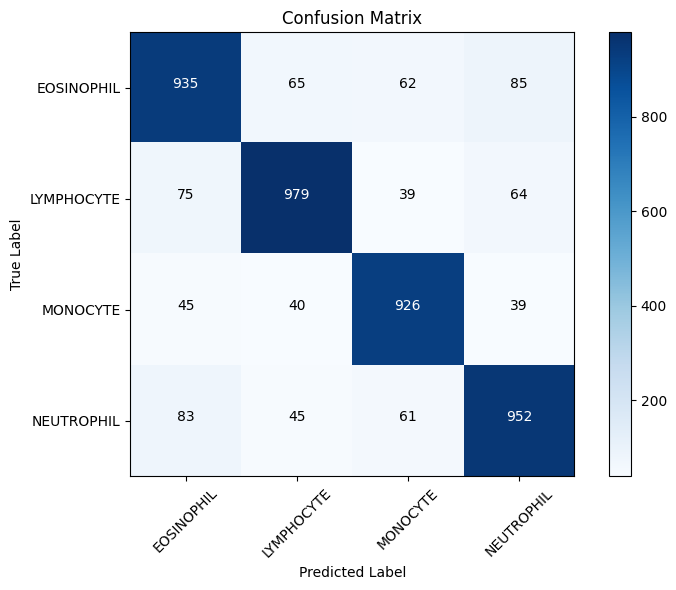

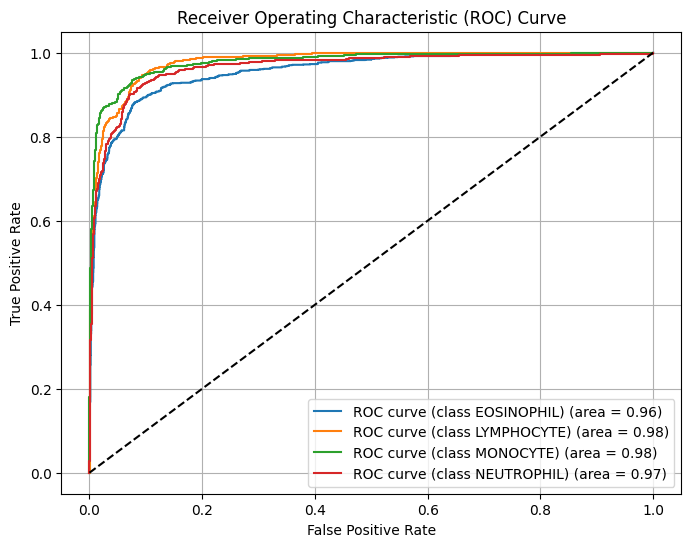

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Create SVM and Decision Tree classifiers
svm_clf = svm.SVC(kernel='linear', probability=True)
dt_clf = DecisionTreeClassifier()

# Create a soft voting ensemble classifier
voting_clf = VotingClassifier(estimators=[('svm', svm_clf), ('dt', dt_clf)], voting='soft')

# Train the ensemble model using the training sets
voting_clf.fit(features_train, labels_train)

# Validate the model using the validation sets
labels_val_pred = voting_clf.predict(features_val)

# Print classification report for the validation set
print("Validation Classification Report:")
print(classification_report(labels_val, labels_val_pred))

# Test the model using the test sets
labels_test_pred = voting_clf.predict(features_test)

# Print classification report for the test set
print("Test Classification Report:")
print(classification_report(labels_test, labels_test_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(labels_test, labels_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

print("\n")

# Predict the probabilities for test dataset
y_probs = voting_clf.predict_proba(features_test)

# Calculate ROC curve and ROC-AUC score for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(labels_test == class_labels[i], y_probs[:, i])
    roc_auc = roc_auc_score(labels_test == class_labels[i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve (class {class_labels[i]}) (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guess curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


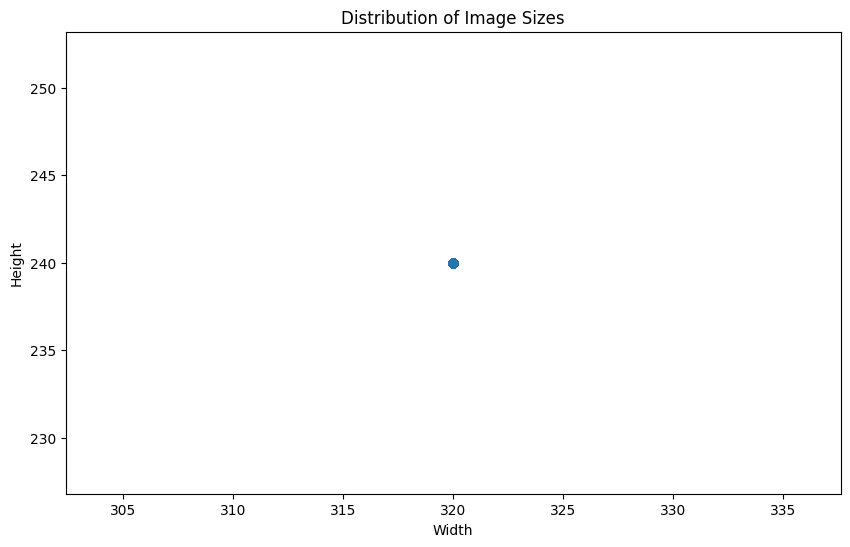

In [18]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Path to your dataset
dataset_path = '/kaggle/working/preprocessed-imagess/TRAIN'

# List to hold image sizes
image_sizes = []

# Iterate over directories in dataset
for dir_name in os.listdir(dataset_path):
    dir_path = os.path.join(dataset_path, dir_name)
    # Check if it's a directory
    if os.path.isdir(dir_path):
        # Iterate over images in directory
        for image_file in os.listdir(dir_path):
            # Open the image
            image = Image.open(os.path.join(dir_path, image_file))
            # Get the size of the image
            size = image.size
            # Add the size to our list
            image_sizes.append(size)

# Convert the list to a numpy array for easier manipulation
image_sizes = np.array(image_sizes)

# Plot the distribution of image sizes
plt.figure(figsize=(10, 6))
plt.scatter(image_sizes[:, 0], image_sizes[:, 1])
plt.title('Distribution of Image Sizes')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
import math

# Directory to load the Original images
train_dirs = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
validation_dirs = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE'

# Define the image size
image_size = 240

# Define the batch size
batch_size = 128
batch_size_val = 16

# Data generator without augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dirs,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dirs,
                                                        target_size=(image_size, image_size),
                                                        batch_size= batch_size_val,
                                                        class_mode='categorical')

# Load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = models.Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will not be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

checkpointer = ModelCheckpoint(filepath='/kaggle/working/model.weights.best.keras',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=50,
                      verbose=1,
                      mode='max')

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

## Specifies the number of training epochs, steps per epoch, validation steps, and callbacks for model checkpointing and early stopping.
history = model.fit(train_generator,
                    steps_per_epoch=math.ceil(train_generator.samples/train_generator.batch_size),
                    epochs=69,
                    validation_data=validation_generator,
                    validation_steps=math.ceil(validation_generator.samples/train_generator.batch_size),
                    verbose=1,
                    callbacks=[checkpointer,early])


2024-05-07 12:24:34.257945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 12:24:34.258073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 12:24:34.393147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 9957 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/69


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-07 12:25:28.192576: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,240,240]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,240,240]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-07 12:25:28.460775: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.268300476s
Trying algo

51/78 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3179 - loss: 1.4199

2024-05-07 12:28:09.936945: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[101,64,240,240]{3,2,1,0}, u8[0]{0}) custom-call(f32[101,64,240,240]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-07 12:28:10.014441: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.077603212s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[101,64,240,240]{3,2,1,0}, u8[0]{0}) custom-call(f32[101,64,240,240]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3448 - loss: 1.3770
Epoch 1: val_loss improved from inf to 1.00152, saving model to /kaggle/working/model.weights.best.keras


W0000 00:00:1715085015.724912     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.3457 - loss: 1.3756 - val_accuracy: 0.5625 - val_loss: 1.0015
Epoch 2/69

Epoch 2: val_loss did not improve from 1.00152
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.0754
Epoch 3/69


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.5790 - loss: 1.0280
Epoch 3: val_loss did not improve from 1.00152
78/78 ━━━━━━━━━━━━━━━━━━━━ 47s 574ms/step - accuracy: 0.5794 - loss: 1.0274 - val_accuracy: 0.5000 - val_loss: 1.0121
Epoch 4/69

Epoch 4: val_loss did not improve from 1.00152
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 1.0781
Epoch 5/69
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.7081 - loss: 0.8249
Epoch 5: val_loss improved from 1.00152 to 0.94749, saving model to /kaggle/working/model.weights.best.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 59s 720ms/step - accuracy: 0.7081 - loss: 0.8247 - val_accuracy: 0.4286 - val_loss: 0.9475
Epoch 6/69

Epoch 6: val_loss improved from 0.94749 to 0.00000, saving model to /kaggle/working/model.weights.best.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/69


Found 2487 images belonging to 4 classes.
 1/78 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step
Accuracy: 0.571773220747889

Confusion Matrix:
[[206 124 143 150]
 [113 408  98   1]
 [182   0 416  22]
 [117  33  82 392]]

Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.33      0.33      0.33       623
  LYMPHOCYTE       0.72      0.66      0.69       620
    MONOCYTE       0.56      0.67      0.61       620
  NEUTROPHIL       0.69      0.63      0.66       624

    accuracy                           0.57      2487
   macro avg       0.58      0.57      0.57      2487
weighted avg       0.58      0.57      0.57      2487



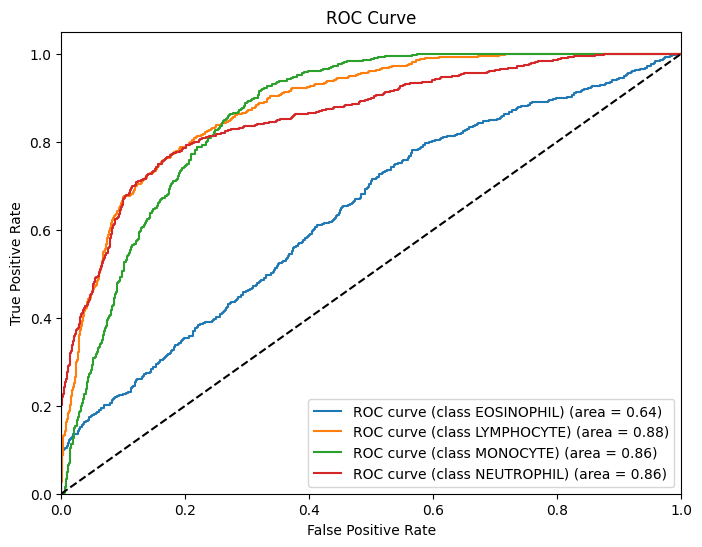

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Directory for test images
test_dirs = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST'  # replace with your test directory

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    test_dirs,
    target_size=(image_size, image_size),
    batch_size=32,  # Adjust batch size if needed
    class_mode='categorical',
    shuffle=False
)

# Predict classes for the test dataset
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes from the test dataset generator
y_true = test_generator.classes

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("\nClassification Report:")
print(class_report)

# Define the class labels
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Calculate ROC curve and ROC AUC for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (class {class_labels[i]}) (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guess curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [23]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the model weights from the best checkpoint
model.load_weights('/kaggle/working/model.weights.best.keras')

# Get class labels from the training generator
class_labels = list(train_generator.class_indices.keys())

# Define a function to predict classes for individual images
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0  # Normalize pixel values
    prediction = model.predict(x)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label

# Example usage:
image_path = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_4055.jpeg'
predicted_class = predict_image(image_path)
print('Predicted class:', predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class: EOSINOPHIL


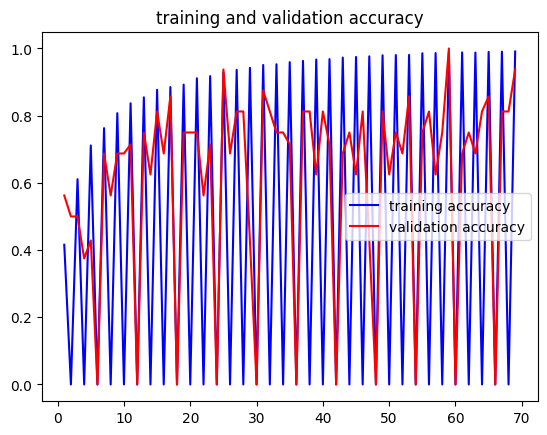

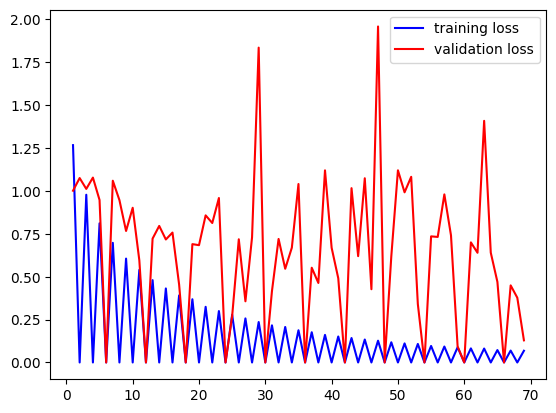

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training accuracy')
plt.plot(epochs,val_acc,'r',label='validation accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'r',label='validation loss')
plt.legend()
plt.figure()
plt.show()